### Import Libraries and Data

Here, I import the following libraries to assist with processing data, performing vector operations, generating random numbers, and generating visuals. Additionally, I am loading the data into local variables to be used in the notebook environment.

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm

In [2]:
mat_contents = scipy.io.loadmat('mnist', appendmat=True)
train_x = np.array(mat_contents['trainX'])
train_y = np.array(mat_contents['trainY'])
test_x = np.array(mat_contents['testX'])
test_y = np.array(mat_contents['testY'])

### Helper Functions (normalization, error, confusion matrices, etc.)

The following three functions are helper functions to perform operations on the input matrices in a shorthand manner to create neat code in the larger classifiers:

In [3]:
def normalize(data):
    return data / 255.0

def pinv(data):
    return np.linalg.pinv(data)

def add_bias(data):
    return np.column_stack((data, np.ones(len(data))))

The following three functions are helper functions to generate a confusion matrix using `matplotlib.pyplot` and calculate accuracies and errors.

In [ ]:
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    fmt = 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def accuracy_score(y_true, y_pred):
    return 100 * (sum(1 for true, pred in zip(y_true, y_pred) if true == pred)) / len(y_true)

def calculate_accuracy_per_class(y_true, y_pred):
    unique_classes = np.unique(y_true)
    accuracies = []

    for class_label in unique_classes:
        class_indices = (y_true == class_label)
        
        # Flatten y_pred if it has shape (N, 1)
        flattened_pred = np.squeeze(y_pred)
        
        correct_predictions = np.sum(flattened_pred[class_indices.flatten()] == class_label)
        total_predictions = np.sum(class_indices)
        
        if total_predictions > 0:
            accuracy = correct_predictions / total_predictions
            accuracies.append((class_label, accuracy))
        else:
            # Handle the case where there are no instances of the class in y_true
            accuracies.append((class_label, 0.0))

    # Sort accuracies based on accuracy in descending order
    accuracies.sort(key=lambda x: x[1], reverse=True)

    for class_label, accuracy in accuracies:
        print("{}: {:.2%} accurate".format(class_label, accuracy))

### Binary Classifier Functions

Given $N$ training data points, we try to find the best linear regression model by solving the following least squares problem:

$$ \operatorname{min}_{\beta, \alpha} \sum_{i = 1}^N \left( y_i - \mathbf{\beta^T \vec{x}_i} - \alpha \right)^2$$

The binary least squares classifier $\hat{f}(\mathbf{x})$ is given by

$$ \hat{f}(\mathbf{x}) = \operatorname{sign}(\mathbf{\beta}^{*T}\mathbf{x} + \alpha^*) $$ 

and can be found by

$$\operatorname{sign}( A^{\dagger} \mathbf{\vec{y}} )$$

where $A^{\dagger}$ is the psuedoinverse of the matrix of input vectors $\mathbf{x}$ and $\mathbf{\vec{y}}$ is the vector of appropriate binary labels. I perform several data preprocessing steps including adding a bias column, normalizng, casting the type as `float32` to speed up the computation of $A^{\dagger} \mathbf{\vec{y}}$, and getting the appropriate binary labels from the training labels. As a result, the function `bin_classifer` returns $\hat{f}(\mathbf{x})$ as a vector of weights, or binary classifer function that when multiplied by test data will return a vector of predicted labels. 

*\*Note: this not include taking the sign, which is later accounted for in the multi-class classifers*.

In [6]:
def bin_label(data, number):
    return np.where(data == number, 1, -1).astype('float32')
    
def bin_classifier(train_x, train_y, number):
    return pinv(add_bias(normalize(train_x)).astype('float32')) @ bin_label(train_y, number).T

### One-Versus-All Classifier

Here the function `ova_classifer` calls the previous implementation of a binary classifier ten times and accumulates the resulting functions. The resulting functions are then individually multiplied by the test set (which is similarly preprocessed to account for the bias term). By taking the maximum index, we return an array of predicted labels for the test data. Our last function provides a way to analyze our test data through the generation of a confusion matrix.

In [7]:
def ova_weights(train_x, train_y):
    return np.array([bin_classifier(train_x, train_y, i) for i in tqdm(range(10), desc="Obtaining weights")])

def ova_classifier(weights, test):
    return np.argmax(add_bias(normalize(test)) @ weights, axis=0)

def ova_conf_mat(ova_preds, test_y, title='Confusion Matrix'):
    conf_matrix = [[0 for _ in range(10)] for _ in range(10)]    
    for i in range(len(test_y[0])):
        conf_matrix[test_y[0][i]][ova_preds[i][0]] += 1
    conf_matrix = np.array(conf_matrix)
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    plot_confusion_matrix(conf_matrix, class_names, title=title)

    acc = accuracy_score(test_y[0], ova_preds)
    print("Accuracy: {:.2f}%".format(acc, 2))
    print("Error rate: {:.2f}%".format(100 - acc, 2))

#### One Versus All Performance on Test Sets

In [8]:
ova_weights = ova_weights(train_x, train_y)

Obtaining weights:   0%|          | 0/10 [00:00<?, ?it/s]

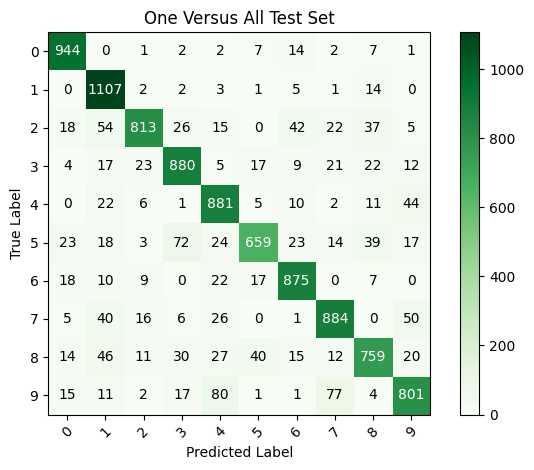

Accuracy: 86.03%
Error rate: 13.97%


In [9]:
ova_preds = ova_classifier(ova_weights, test_x)
ova_conf_mat(ova_preds, test_y, title='One Versus All Test Set')

In [10]:
calculate_accuracy_per_class(ova_preds, test_y)

2: 91.76% accurate
0: 90.68% accurate
5: 88.22% accurate
6: 87.94% accurate
7: 85.41% accurate
3: 84.94% accurate
8: 84.33% accurate
9: 84.32% accurate
1: 83.55% accurate
4: 81.20% accurate


The one versus all classifier generalizes decently on the test data, with achieving over 80% accuracy. This is good considering we train only ten binary classifiers. The classifier has the lowest accuracy when classifying the digit 4, achieving only 81.20% accuracy.

### One-Versus-One Classifier

Here I created a one versus one classifier by considering only a subset of our training data that includes only a unique pair of labels `a` and `b`, obtaining the solution to the least squares problem on that subset of input data and labels. I then obtain the predicted labels for each of those solutions by multiplying it by the test data. By looping over every pair of unique pairs and keeping track of their predictions in a `votes` matrix, I can derive the best prediction over all uninque pairs by taking the max of the votes (choosing the smallest index to break ties). Lastly, I have another function to generate a confusion matrix, as the previous function expected the results matrix in a different shape.

In [11]:
def ovo_single_weights(train_x, train_y, a, b):
    aug_y = train_y.T
    mask = np.where((aug_y == a) | (aug_y == b))[0]
    aug_x = add_bias(train_x[mask])
    aug_y = bin_label(aug_y[mask], a)
    return pinv(aug_x) @ aug_y

def ovo_single_preds(weights, test, a, b):
    return np.where((add_bias(test) @ weights)[:, 0] >= 0, 1, -1).astype('float32')   

def ovo_weights(train_x, train_y):
    pairs = [(i, j) for i in range(10) for j in range(i+1, 10)]
    weights = {}
    for pair in tqdm(pairs):
        weights[pair] = ovo_single_weights(train_x, train_y, pair[0], pair[1])
    return weights

def ovo_classifier(weights, test):
    votes = np.zeros((len(test), 10), dtype=int)
    for pair, pair_weights in weights.items():
        i, j = pair
        preds = ovo_single_preds(pair_weights, test, i, j)
        votes[preds == 1, i] += 1
        votes[preds == -1, j] += 1
    return np.argmax(votes, axis=1)

def ovo_conf_matrix(ovo_preds, test_y, title='Confusion Matrix'):
    conf_matrix = [[0 for _ in range(10)] for _ in range(10)]    
    for i in range(len(test_y[0])):
        conf_matrix[test_y[0][i]][ovo_preds[i]] += 1
    conf_matrix = np.array(conf_matrix)
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    plot_confusion_matrix(conf_matrix, class_names, title)

    acc = accuracy_score(test_y[0], ovo_preds)
    print("Accuracy: {:.2f}%".format(acc, 2))
    print("Error rate: {:.2f}%".format(100 - acc, 2))

#### One Versus One Performance on Test Sets

In [12]:
ovo_weight = ovo_weights(train_x, train_y)

  0%|          | 0/45 [00:00<?, ?it/s]

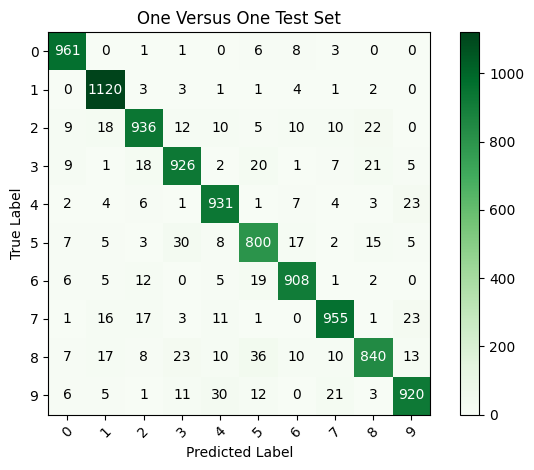

Accuracy: 92.97%
Error rate: 7.03%


In [13]:
ovo_preds = ovo_classifier(ovo_weight, test_x)
ovo_conf_matrix(ovo_preds, test_y, title='One Versus One Test Set')

In [14]:
calculate_accuracy_per_class(ovo_preds, test_y)

0: 95.34% accurate
7: 94.18% accurate
6: 94.09% accurate
1: 94.04% accurate
2: 93.13% accurate
9: 93.02% accurate
8: 92.41% accurate
4: 92.36% accurate
3: 91.68% accurate
5: 88.79% accurate


The one versus one classifier generalizes decently on the test data, achieving over 90% overall accuracy. This seems to be diminishing returns considering we are training 45 pairs of classifiers compared to our 10 classifiers in one versus one. The classifier has the lowest accuracy when classifying the digit 5, achieving only 88.79% accuracy.

### Feature Maps

Here are some helper functions to help perform the nonlinearity functions, generate a random matrix $\mathbf{W} \in \mathcal{R}^{L \times d}$ with $\mathbf{W}_{i,j} \sim \mathcal{N}(0,1)$, and apply the nonlinear functions to our input data. Here, the function `feature_map` returns

$$
\mathbf{h(x)} = 
\begin{bmatrix}
g(\mathbf{w_1^Tx} + b_1) \\
g(\mathbf{w_2^Tx} + b_2) \\
\vdots \\
g(\mathbf{w_L^Tx} + b_L)
\end{bmatrix}
$$

where $g$ represents one of `identity(x)`, `sigmoid(x)`, `relu(x)`, and `sin(x)` as defined below. The bias is considered by adding a bias column to the input data and an additional column of random numbers in the $\mathbf{W}$ matrix. The following can then be applied to the input training data and input testing data before running the one-versus-one multiclass classifiers in a similar manner as before.

In [15]:
def identity(x):
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)
    
def sin(x):
    return np.sin(x)

def generate_W(train_x, i):
    return np.random.normal(0, 1, (train_x.shape[1] + 1, i))

def feature_map(train_x, W, function=identity):
    return function( add_bias(normalize(train_x)) @ W )

#### Feature Map with L=1000 Performance

Here, the one-versus-one classifers are run after applying all different functions $g$ (in separate runs) defined by `identity(x)`, `sigmoid(x)`, `relu(x)`, and `sin(x)` with `L = 1000`. `L = 1000` means the function $h(x)$ is mapping the vector of length 784 (for 784 pixels) to a vector of length 1000. The new vector $h(x)$ acts as the new input to the one-versus-one classifier. Additionallly, all random matrices $\mathbf{W}$ are the same to avoid erroneous output.

In [16]:
W = generate_W(train_x, 1000)

#### Identity Function on Test and Train Sets (L=1000)

In [17]:
id_train_x = feature_map(train_x, W, function=identity)
id_test_x = feature_map(test_x, W, function=identity)
id_weights = ovo_weights(id_train_x, train_y)

  0%|          | 0/45 [00:00<?, ?it/s]

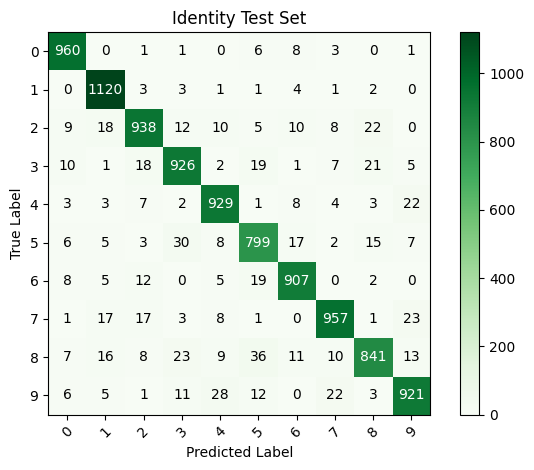

Accuracy: 92.98%
Error rate: 7.02%


In [18]:
id_test_preds = ovo_classifier(id_weights, id_test_x)
ovo_conf_matrix(id_test_preds, test_y, title='Identity Test Set')

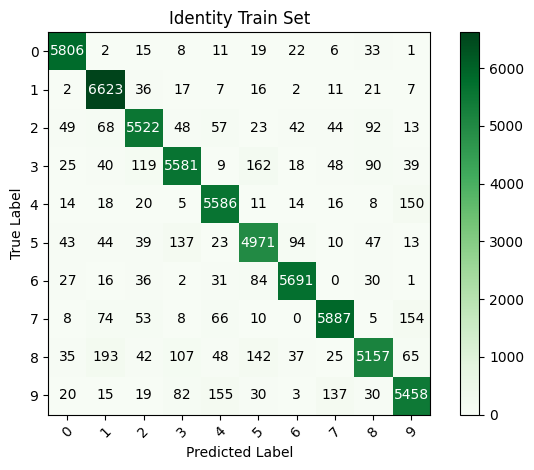

Accuracy: 93.80%
Error rate: 6.20%


In [19]:
id_train_preds = ovo_classifier(id_weights, id_train_x)
ovo_conf_matrix(id_train_preds, train_y, title='Identity Train Set')

#### ReLU Function on Test and Train Sets (L=1000)

In [20]:
relu_train_x = feature_map(train_x, W, function=relu)
relu_test_x = feature_map(test_x, W, function=relu)
relu_weights = ovo_weights(relu_train_x, train_y)

  0%|          | 0/45 [00:00<?, ?it/s]

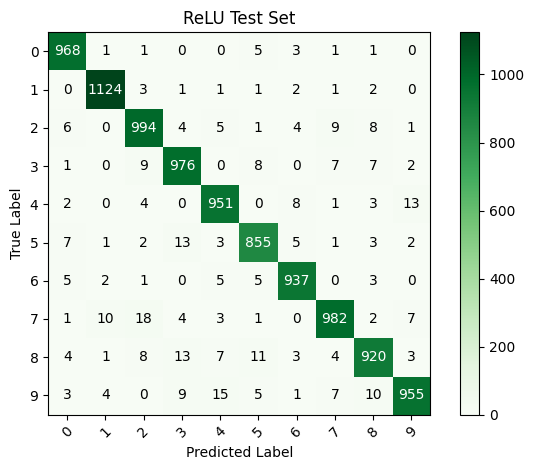

Accuracy: 96.62%
Error rate: 3.38%


In [21]:
relu_test_preds = ovo_classifier(relu_weights, relu_test_x)
ovo_conf_matrix(relu_test_preds, test_y, title='ReLU Test Set')

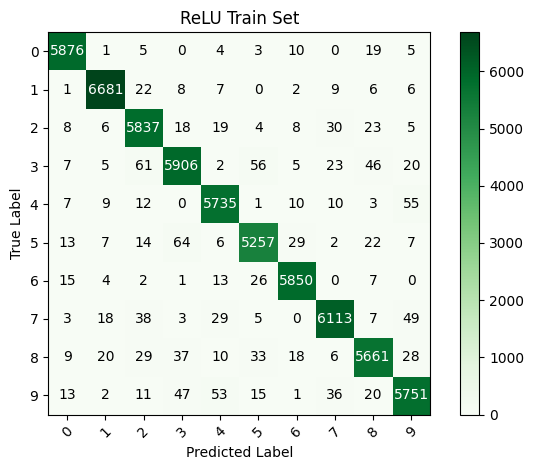

Accuracy: 97.78%
Error rate: 2.22%


In [22]:
relu_train_preds = ovo_classifier(relu_weights, relu_train_x)
ovo_conf_matrix(relu_train_preds, train_y, title='ReLU Train Set')

#### Sin Function on Test and Train Sets (L=1000)

In [23]:
sin_train_x = feature_map(train_x, W, function=sin)
sin_test_x = feature_map(test_x, W, function=sin)
sin_weights = ovo_weights(sin_train_x, train_y)

  0%|          | 0/45 [00:00<?, ?it/s]

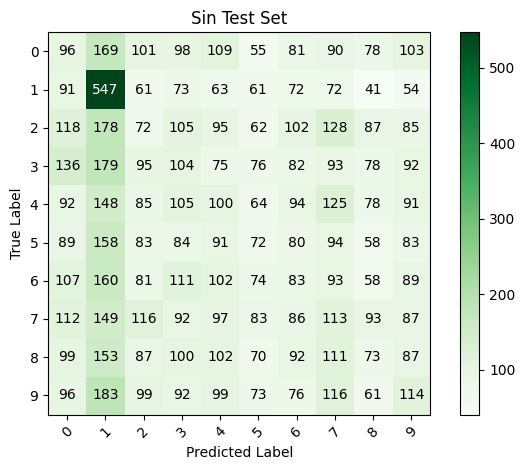

Accuracy: 13.74%
Error rate: 86.26%


In [24]:
sin_test_preds = ovo_classifier(sin_weights, sin_test_x)
ovo_conf_matrix(sin_test_preds, test_y, title='Sin Test Set')

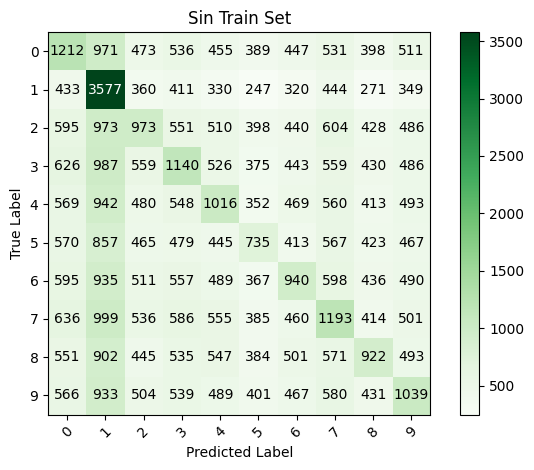

Accuracy: 21.25%
Error rate: 78.75%


In [25]:
sin_train_preds = ovo_classifier(sin_weights, sin_train_x)
ovo_conf_matrix(sin_train_preds, train_y, title='Sin Train Set')

#### Sigmoid Function on Test and Train Sets (L=1000)

In [26]:
sig_train_x = feature_map(train_x, W, function=sigmoid)
sig_test_x = feature_map(test_x, W, function=sigmoid)
sig_weights = ovo_weights(sig_train_x, train_y)

  0%|          | 0/45 [00:00<?, ?it/s]

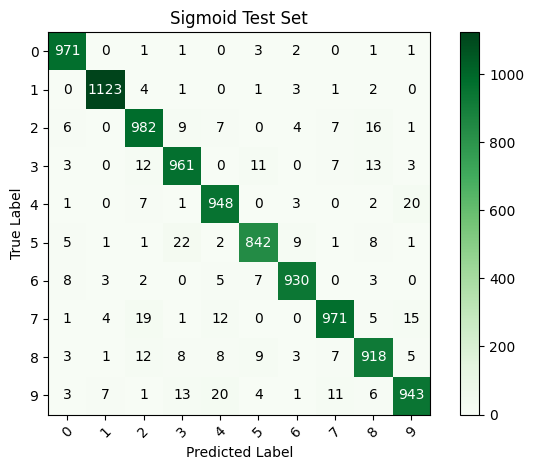

Accuracy: 95.89%
Error rate: 4.11%


In [27]:
sig_test_preds = ovo_classifier(sig_weights, sig_test_x)
ovo_conf_matrix(sig_test_preds, test_y, title='Sigmoid Test Set')

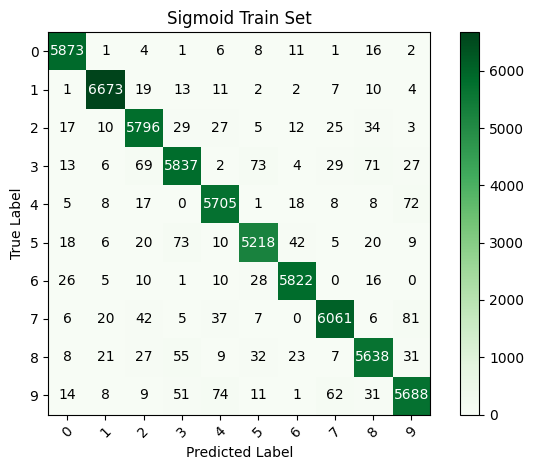

Accuracy: 97.19%
Error rate: 2.81%


In [28]:
sig_train_preds = ovo_classifier(sig_weights, sig_train_x)
ovo_conf_matrix(sig_train_preds, train_y, title='Sigmoid Train Set')

By adding a non-linearity through the feature mappings, our better performing classifier (one versus one) improves accuracy in all cases other than the sinusoid function. Additionally, the classifier consistently performs better when used on the training set over the test set, again, in all cases other than the sinusoid function. This is due to the periodic nature of the sin function (the sin function does not consistently map large values to large values and small values to small values). However overall, the feature mapping that generalizes the best is the ReLU function, achieving the highest accuracy of 96.62% on the test set.

### Varying the values for L

In [29]:
def eval_features(preds, test_y):
    count = 0
    for i in range(len(test_y[0])):
        if test_y[0][i] == preds[i]:
            count += 1

    return 100 - (100 * count / len(test_y[0]))

def vary_L(train_x, train_y, test_x, test_y, L, function=identity):
    test_errors = [0 for _ in range(len(L))]
    train_errors = [0 for _ in range(len(L))]
    for i in range(len(L)):
        W = generate_W(train_x, L[i])
        weights = ovo_weights(feature_map(train_x, W, function), train_y)
        test_preds = ovo_classifier(weights, feature_map(test_x, W, function))
        train_preds = ovo_classifier(weights, feature_map(train_x, W, function))
        test_errors[i] = eval_features(test_preds, test_y)
        train_errors[i] = eval_features(train_preds, train_y)
    return test_errors, train_errors

def plot_L_versus_error(L, errors_1, errors_2, title="Percent Error Versus L"):
    plt.plot(L, errors_1, marker='o', linestyle='-', color='b', label='Test Error')
    plt.plot(L, errors_2, marker='o', linestyle='-', color='y', label='Train Error')
    plt.xlabel('L')
    plt.ylabel('Error')
    plt.title(title)
    # Add labels for each point
    for i, txt in enumerate(errors_1):
        plt.text(L[i], errors_1[i], f'{txt:.2f}%', ha='right', va='top')

    for i, txt in enumerate(errors_2):
        plt.text(L[i], errors_2[i], f'{txt:.2f}%', ha='left', va='bottom')
    plt.legend()
    plt.show()

In [30]:
L = np.linspace(500, 3500, 10).astype('int')

#### Varying L on the ReLU Function

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

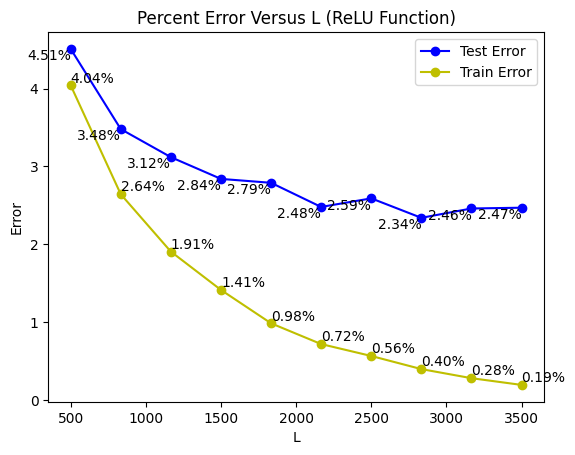

In [31]:
test_errors, train_errors = vary_L(train_x, train_y, test_x, test_y, L, function=relu)
plot_L_versus_error(L, test_errors, train_errors, title="Percent Error Versus L (ReLU Function)")

The above error rates are derived using the one-versus-one classifier from problem 1 using a ReLU as our nonlinear function. As we increase the number of L features, we see a consistent increase in accuracy when classifying on the training set. This is a result of overfitting our classifier to training data. As we increase the number of features, we get closer to a one-to-one mapping from an input vector to a feature. In contrast, our test error seems to plateau at about 2.4%, achieving lowest error at 2.34% and slowly increasing to 2.46% and 2.47%. This is likely because at ~L=3000, we have begun to overfit to noise, resulting in a lack of generalization.